### Medical Image Processing Final Project 2025

This notebook contains the solution to the final project task in the Medical Image Processing course. The task involves visualizing, analyzing, and segmenting 3D CT volumes with corresponding segmentation masks for liver and tumor structures. 

The project is organized into the following key steps:

1. Loading and sorting CT slices based on spatial metadata to construct a 3D CT volume.
2. Loading and mapping segmentation masks (liver and tumor) to the corresponding CT slices using DICOM spatial metadata.
3. Visualizing representative slices with overlaid segmentation masks to assess anatomical alignment.
4. Constructing a 3D tumor mask volume and generating a rotating Maximum Intensity Projection (MIP) animation to explore tumor distribution.
5. Implementing a semi-automatic segmentation algorithm.
6. Evaluating the segmentation performance using numerical metrics such as precision, sensitivity, and specificity.
7. Visualizing and comparing ground truth and segmented results for qualitative assessment.

#### Author: Halidu Abdulai

### Table of Content
[Task 1: Loading and Visualizing the Reference CT image](#task-1---loading-and-visualizing-the-reference-ct-image)
- [1.1 Loading and Sorting the Refernce CT image](#loading-and-sorting-ct-images)
- [1.2 Loading and mapping segmentation masks to CT slices](#loading-and-mapping-segmentation-masks-to-ct-slices)
- [1.3 Construction 3D Tumor mask volume](#construct-the-3d-tumor-mask-volume)
- [1.4 Visualizing Sample slices with Liver and Tumor overlays](#visualizing-sample-slices-containing-liver-and-tumor-segmentations)
- [Generating Rotating MIP GIF along the Coronal-Sagittal planes](#generate-rotating-mip-animation)

[Task 2: Semi-Automatic 3D image Segmentation](#task-2-3d-image-segmentation)
- [2.1 Tumor mask bounding-box and centriod extraction](#extracting-tumor-bounding-box-and-centroid)
- [2.2 Estimating Tumor mask using Region Growing Algorithm](#estimating-tumor-region-using-region-growing-algorithm)
- [2.3 Numerical and Visual Performance Evaluation](#evaluation-and-comparison)

### Import Libraries

In [15]:
import pydicom
import highdicom as hd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import colors
import os
import glob 
import imageio
import SimpleITK as sitk
from collections import defaultdict
import math, time, copy 


#### Task 1 - Loading and Visualizing the Reference CT Image 

In [ ]:
# Paths to dataset
ref_ct_dir = r"Data\RadCTTACEomics_0222\30_EQP_Ax5.00mm" # Path to reference CT series
input_ct_dir = r"Data\RadCTTACEomics_0222\11_AP_Ax5.00mm" # Path to input CT series
tumor_seg_path = r"Data\RadCTTACEomics_0222\30_EQP_Ax5.00mm_ManualROI_Tumor.dcm"
liver_seg_path = r"Data\RadCTTACEomics_0222\30_EQP_Ax5.00mm_ManualROI_Liver.dcm"
output_dir = "Task1_output"

#### Loading and Sorting CT image

To begin constructing the 3D CT volume, the first task is to load and sort all the CT slices. Since the filenames themselves don’t reflect the actual spatial ordering of the slices, we can't rely on sorting by name. Instead, we can use metadata embedded in each DICOM file.

By exploring the slices in 3D Slicer, I confirmed that the ImagePositionPatient attribute provides the spatial coordinates of each slice, specifically along the z-axis for axial CT scans (since we are working with axial CT scans data). This z-value essentially tells us the order in which the slices should appear in the final 3D volume.

We can take the following steps to load, sort and contruct the 3D volume:

1. Load all DICOM files: Collect all .dcm files from the input directory containing the dicom files for the CT slices. For each file, read it using pydicom and ensure that all files have the same AcquisitionNumber.

2. Sort the slices using z-position: Each slice’s z-position is extracted from ImagePositionPatient[2]. Once all valid slices are collected, sort them based on this z-position so they’d be arranged in the correct anatomical order.

3. Stack pixel data to build the CT volume: After sorting, pull the pixel arrays from each slice and stack them along a new axis using np.stack(..., axis=-1) to form the full 3D volume. This way, each slice forms a 2D image along one axis of the volume, and together they create the complete CT scan.

In [16]:
def load_and_sort_ct_slices(ct_dir):
    """
    Load and sort CT slices, and verifies if slices have same acquisition number.

    Reads DICOM files, extracts relevant metadata, checks for consistent
    AcquisitionNumber (if present), and sorts slices by Z-position.

    Args:
        ct_dir (str): Directory containing DICOM files.

    Returns:
        list: A list of dictionaries, where each dictionary contains the
              pydicom dataset ('dataset'), Z-position ('z_pos'), rows ('rows'),
              and columns ('cols') for a slice, sorted by 'z_pos'.

    Raises:
        FileNotFoundError: If no DICOM files are found in the directory.
        ValueError: If no valid CT slices are loaded or if multiple
                    AcquisitionNumbers are detected.
    """
    ct_slices = [] # List to hold the slices
    first_acquisition_number = None # Store the Acq. Number of the first valid slice
    first_series_uid = None # Store the Series UID of the first valid slice

    ct_files = glob.glob(os.path.join(ct_dir, '*.dcm')) # Get all DICOM files

    if not ct_files:
        raise FileNotFoundError(f"Error: No DICOM files found in {ct_dir}")

    print(f"Found {len(ct_files)} CT files. Loading, verifying, and sorting...")

    for f_path in ct_files:
        try:
            # Read the DICOM file
            ds = pydicom.dcmread(f_path) 

            # Check for essential tags for positioning and pixel data
            if not all(hasattr(ds, tag) for tag in ['ImagePositionPatient', 'pixel_array', 'Rows', 'Columns', 'SeriesInstanceUID']):
                print(f"Skipping file {f_path}: Missing required tags (ImagePositionPatient, pixel_array, Rows, Columns, SeriesInstanceUID) or pixel data.")
                continue

            # Series Consistency Check 
            current_series_uid = ds.SeriesInstanceUID
            if first_series_uid is None:
                first_series_uid = current_series_uid
            elif current_series_uid != first_series_uid:
                print(f"Warning: File {f_path} belongs to a different series ({current_series_uid}) than the first slice ({first_series_uid}). Skipping.")
                continue # Skip files from different series

            # Acquisition Number Check 
            current_acquisition_number = None
            if hasattr(ds, 'AcquisitionNumber'):
                current_acquisition_number = ds.AcquisitionNumber
                # Handle potential None value if tag exists but is empty
                if current_acquisition_number is None:
                     print(f"Note: File {f_path} has an empty AcquisitionNumber tag.")

            if first_acquisition_number is None and current_acquisition_number is not None:
                # Store the first encountered acquisition number
                first_acquisition_number = current_acquisition_number
                # print(f"  First AcquisitionNumber found: {first_acquisition_number} in {f_path}")
            elif current_acquisition_number is not None and first_acquisition_number is not None:
                # Compare subsequent acquisition numbers
                if current_acquisition_number != first_acquisition_number:
                    # Found a different acquisition number - raise an error
                    raise ValueError(
                        f"Error: Multiple AcquisitionNumbers detected! "
                        f"Expected {first_acquisition_number}, but found {current_acquisition_number} in file {f_path}. "
                        f"Ensure all slices belong to the same acquisition."
                    )
            # If current_acquisition_number is None but first_acquisition_number is set,
            # it might indicate inconsistent tagging, but we allow it for now.
            # TODO: Check with Dr. Biblioni if we need to skip such slices

            # Store Valid Slice Data
            # Store the dataset and its Z-position (for axial slices) along with dimensions
            ct_slices.append({
                'dataset': ds,
                'z_pos': float(ds.ImagePositionPatient[2]),
                'rows': ds.Rows,
                'cols': ds.Columns,
                'acq_num': current_acquisition_number # May not use it, just adding it in case I'd reference it later
            })

        except Exception as e:
            # Catch potential pydicom read errors or other issues
            print(f"Error reading or processing file {f_path}: {e}")

    # Final Checks and Sorting
    if not ct_slices:
        raise ValueError("Error: No valid CT slices were loaded.")

    # Sort slices based on the Z-coordinate of ImagePositionPatient
    ct_slices.sort(key=lambda x: x['z_pos'])

    print(f"Successfully loaded and sorted {len(ct_slices)} CT slices.")
    if first_acquisition_number is not None:
        print(f"Verified all loaded slices belong to AcquisitionNumber: {first_acquisition_number}")
    elif len(ct_slices) > 0:
         print("Note: AcquisitionNumber tag was not found or consistently absent in loaded slices.")

    return ct_slices

In [4]:
ref_ct_slices = load_and_sort_ct_slices(ref_ct_dir)
if not ref_ct_slices:
    raise ValueError("Error: No valid CT slices loaded.")

# Create a 3D numpy array to hold the CT volume
# Note: All slices have the same dimensions and orientation upon inspection with 3D Slicer
try:
    ct_volume = np.stack([s['dataset'].pixel_array for s in ref_ct_slices], axis=-1)
    print(f"Created CT volume with shape: {ct_volume.shape}")
except Exception as e:
    print(f"Could not stack CT slices into volume: {e}")
    ct_volume = None 

Found 42 CT files. Loading, verifying, and sorting...
Successfully loaded and sorted 42 CT slices.
Verified all loaded slices belong to AcquisitionNumber: 3
Created CT volume with shape: (512, 512, 42)


#### Loading and Mapping Segmentation Masks to CT Slices
Next, we need to load and map the segmentations (liver and tumor) to the CT slices using ImagePositionPatient.
To do this, I followed the following steps:

1. Load the segmentation file (tumor or liver): 
We begin by reading in the `segmentation DICOM file using pydicom`. 

2. Parse the loaded DICOM dataset into a segmentation object using highdicom’s `Segmentation` class: 
Once the dataset is loaded, we use highdicom.seg.Segmentation.from_dataset() to convert it into a highdicom Segmentation object. This makes it easier to access the segmentation pixel data and related metadata.

3. Loop through the segmentation frames and extract their Z-positions:
We iterate through the PerFrameFunctionalGroupsSequence of the DICOM segmentation dataset. For each frame, we access the z-coordinate (axial position) using PlanePositionSequence[0].ImagePositionPatient[2]. This is the same metadata field we used earlier when sorting CT slices.

4. Map each frame (mask) to its corresponding Z-position:
Using the extracted z-position as a key, we store each binary mask frame in a dictionary (segmentations). For each z-position, we create a sub-dictionary where each segmentation type (e.g., ‘Liver’, ‘Tumor’) is stored separately. We apply a threshold to the pixel values so that each mask becomes binary (i.e., values > 0 are considered part of the segmented region).

At the end of this step, we’ve created a mapping between z-positions and their corresponding segmentation masks for both liver and tumor. 

>Note: I am sure there may be a simpler way to load and map the segmentation masks to the corresponding CT slices. However, highdicom's docs seemed a bit old and wasn't really helpful. I thought through the above apprach, tried it, and it worked for me!

In [5]:
def load_segmentation(seg_path: str, seg_name: str, segmentations: dict) -> dict:
    """
    Loads segmentation frames and maps them to Z positions.

    Args:
        seg_path (str): Path to the DICOM segmentation file.
        seg_name (str): Name to assign to this segmentation (e.g., 'Liver', 'Tumor').
        segmentations (dict): Dictionary (keyed by Z-pos) to store loaded masks.
                              This dictionary is modified in place.

    Returns:
        dict: The updated segmentations dictionary.
    """
    if not os.path.exists(seg_path):
        print(f"Warning: Segmentation file not found at {seg_path}")
        return segmentations # Return the dictionary unchanged

    try:
        seg_ds = pydicom.dcmread(seg_path) 
        # Use highdicom to parse the segmentation object
        seg = hd.seg.Segmentation.from_dataset(seg_ds)
        print(f"Loaded {seg_name} segmentation with {len(seg.pixel_array)} frames.")

        # Extract pixel array (NumPy array)
        seg_pixel_array = seg.pixel_array # Shape: (frames, rows, columns)

        # Check if PerFrameFunctionalGroupsSequence exists
        if not hasattr(seg_ds, 'PerFrameFunctionalGroupsSequence'):
             print(f"Error: Segmentation file {seg_path} missing PerFrameFunctionalGroupsSequence. Cannot map frames.")
             return segmentations

        # Map frames to CT slices using ImagePositionPatient
        mapped_frames = 0
        for i, frame_group in enumerate(seg_ds.PerFrameFunctionalGroupsSequence):
             # Check structure for position information
            if not hasattr(frame_group, 'PlanePositionSequence') or \
               not frame_group.PlanePositionSequence or \
               not hasattr(frame_group.PlanePositionSequence[0], 'ImagePositionPatient'):
                 print(f"Warning: Frame {i} in {seg_path} missing position info. Skipping.")
                 continue

            # Get position for this frame
            frame_pos = frame_group.PlanePositionSequence[0].ImagePositionPatient
            frame_z_pos = float(frame_pos[2])

            # Store the mask (frame) in our dictionary, keyed by Z-position
            if frame_z_pos not in segmentations:
                segmentations[frame_z_pos] = {}
            # Store the actual mask data for this segmentation type
            segmentations[frame_z_pos][seg_name] = (seg_pixel_array[i] > 0) # binary mask
            mapped_frames += 1

        print(f"Mapped {mapped_frames} {seg_name} frames to Z-positions.")

    except Exception as e:
        print(f"Error loading or processing {seg_name} segmentation from {seg_path}: {e}")

    return segmentations

In [6]:
segmentations = defaultdict(str) # Dictionary to hold masks keyed by Z-position

# Load both liver and tumor segmentations
segmentations = load_segmentation(liver_seg_path, 'Liver', segmentations)
segmentations = load_segmentation(tumor_seg_path, 'Tumor', segmentations)

Loaded Liver segmentation with 28 frames.
Mapped 28 Liver frames to Z-positions.
Loaded Tumor segmentation with 14 frames.
Mapped 14 Tumor frames to Z-positions.


#### Visualizing sample slices containing Liver and Tumor Segmentations
After loading and organizing the CT slices and segmentation masks, the next step is to visualize some representative slices where both liver and tumor segmentations are present. This allows us to qualitatively assess the correctness of the masks and their spatial alignment with the underlying anatomy.

To achieve this, I followed these steps:

1. Apply windowing to enhance CT contrast:
CT data is stored in Hounsfield Units (HU), and not all HU values are equally useful for soft tissue visualization. Using a soft tissue window (level = 50, width = 400), I rescaled the CT intensities to the display range [0, 1]. This makes anatomical structures easier to see. 

2. Prepare RGB version of the CT image:
After windowing, the single-channel grayscale image is expanded into three channels using np.stack() to make it RGB. This allows us to overlay colored segmentation masks later on.

3. Overlay segmentation masks with alpha blending:
Using the defined function, I blended the liver and tumor masks on top of the CT slice by first blending the liver with the CT image, and then the resulting image is blended with the tumor mask. Each mask is applied with its respective color—green for liver and red for tumor—and an alpha value of 0.25 for transparency. This helps in visualizing where each structure lies in relation to the anatomy without completely obscuring the CT image.

4. Display the images side-by-side:
For each slice that contains both a liver and tumor mask, I display three panels:
    - The raw CT slice (in HU),
    - The windowed CT image,
    - The final composite image with liver and tumor overlays.

In [7]:
# Alpha Fusion Function 
def apply_alpha_overlay(image_rgb: np.ndarray, mask: np.ndarray, color: tuple, alpha: float):
    """
    Apply alpha blending of a mask onto an RGB image.
    Args:
        image_rgb: RGB image (H, W, 3) in [0, 1].
        mask: Binary mask (H, W).
        color: RGB tuple (R, G, B).
        alpha: Alpha value for blending.
    Returns:
        RGB image with alpha-blended overlay applied.
    """
    blended = image_rgb.copy()
    mask_bool = mask > 0
    for c in range(3):
        blended[..., c][mask_bool] = (
            (1 - alpha) * blended[..., c][mask_bool] + alpha * color[c]
        )
    return blended

# CT Windowing Function 
def apply_window(image, level, width):
    """
    Apply windowing to a CT image using the specified window level and width.

    Windowing enhances the visual contrast of CT images by mapping a selected range
    of Hounsfield Unit (HU) values to the display intensity range [0, 1].

    Args:
        image (np.ndarray): 2D array representing the CT slice (typically in HU).
        level (float): Window level (center of the HU range to display).
        width (float): Window width (range of HU values to include around the level).

    Returns:
        np.ndarray: Normalized image array with values scaled to [0, 1] based on the
                    specified windowing parameters.
    """
    lower = level - (width / 2)
    upper = level + (width / 2)
    image = image.astype(np.float32)
    windowed = np.clip(image, lower, upper)
    norm_factor = (upper - lower) if (upper - lower) != 0 else 1.0
    return (windowed - lower) / norm_factor


Visualizing slices containing both Liver and Tumor masks...
Processing Slice Index: 18, Z-Position: -152.12


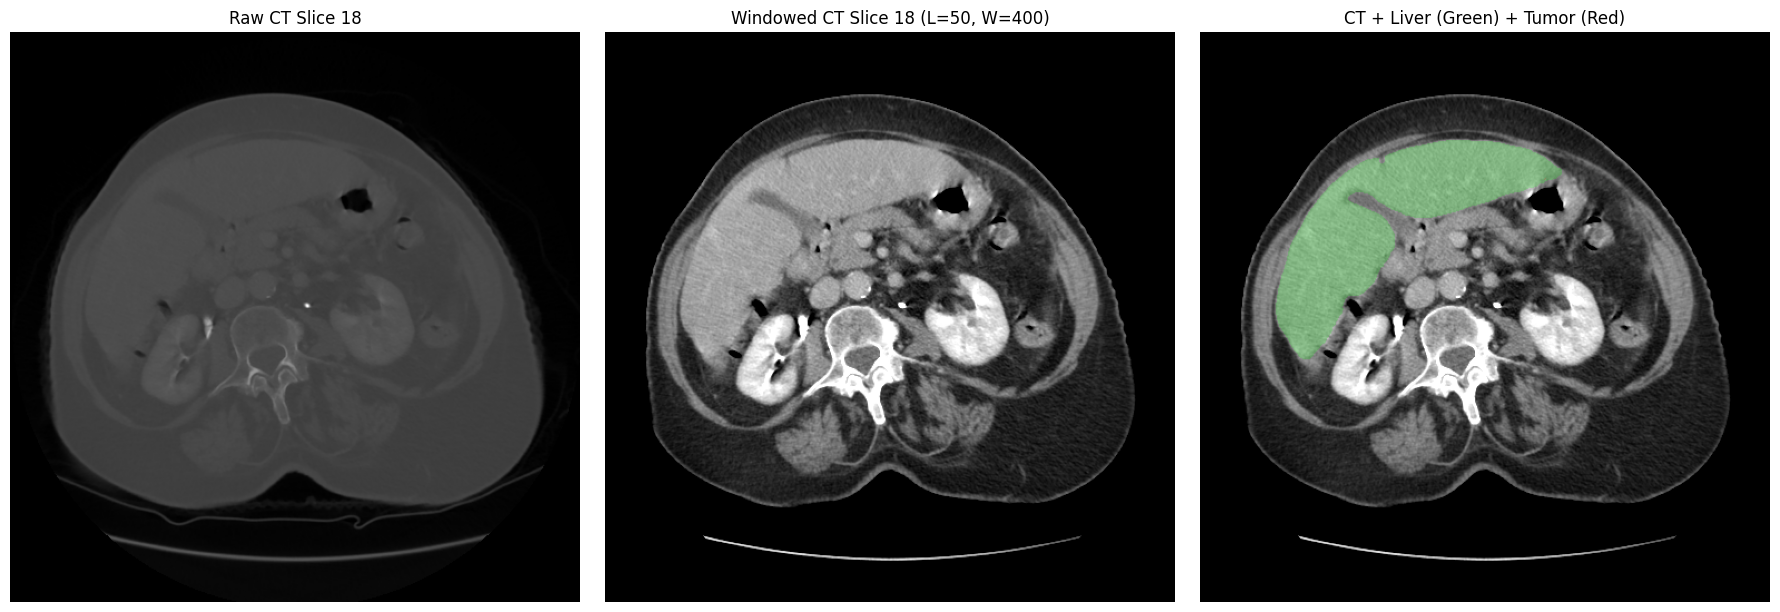

Processing Slice Index: 19, Z-Position: -147.12


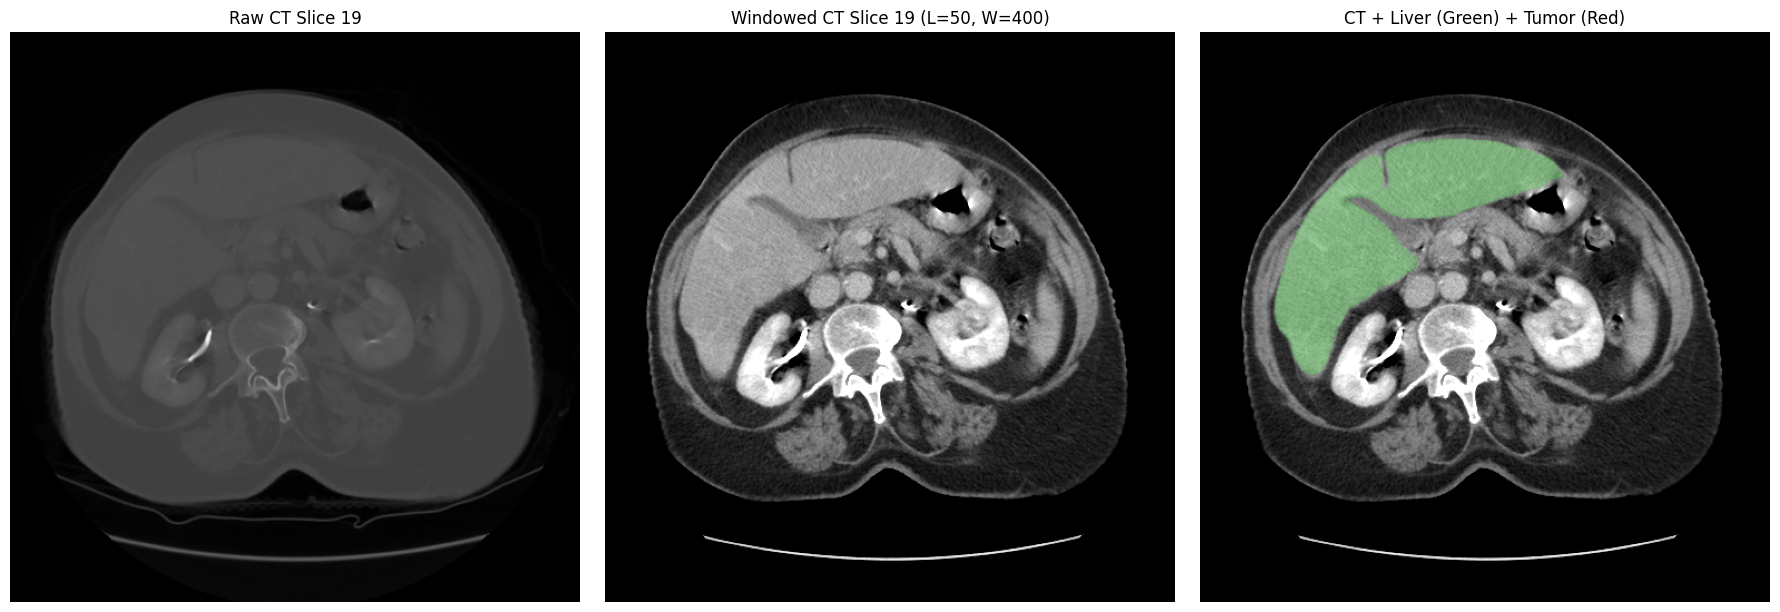

Processing Slice Index: 25, Z-Position: -117.12


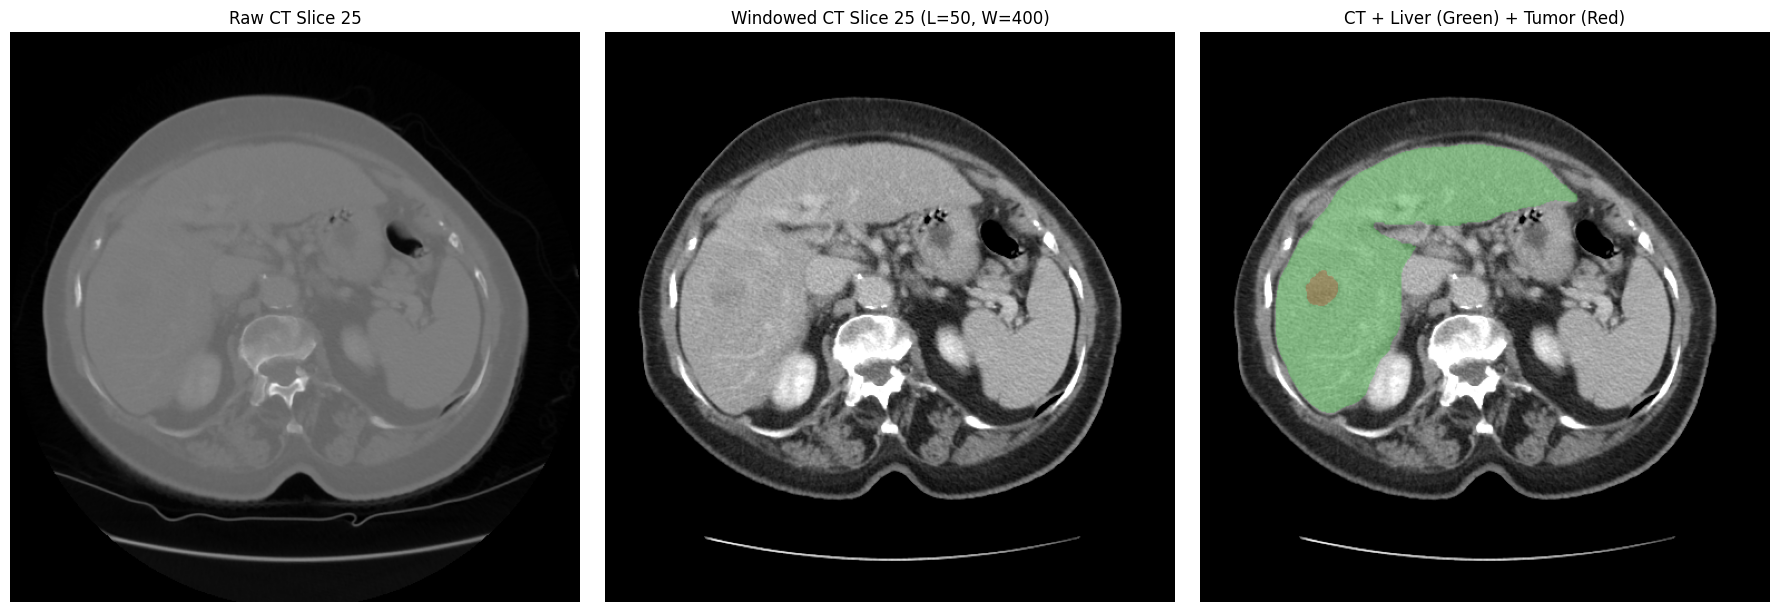

Processing Slice Index: 26, Z-Position: -112.12


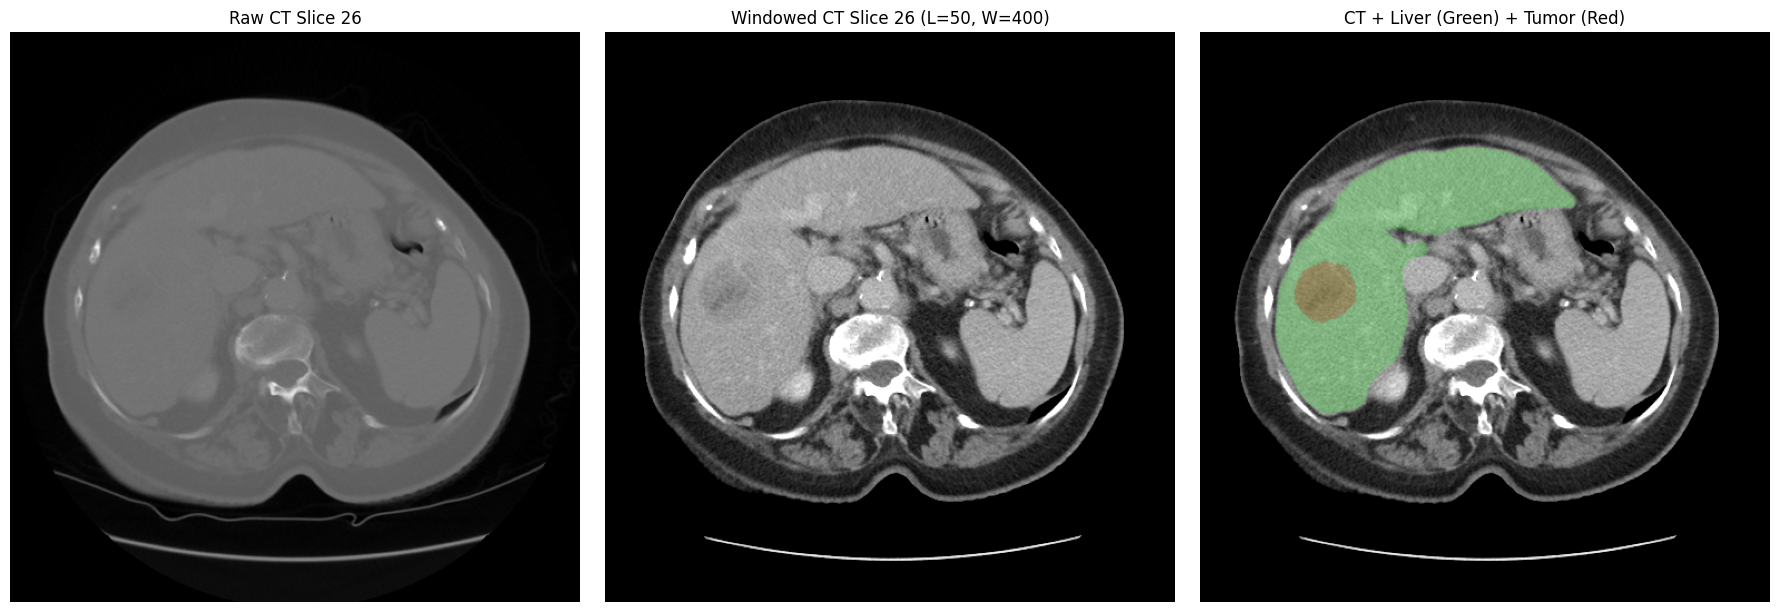

Processing Slice Index: 27, Z-Position: -107.12


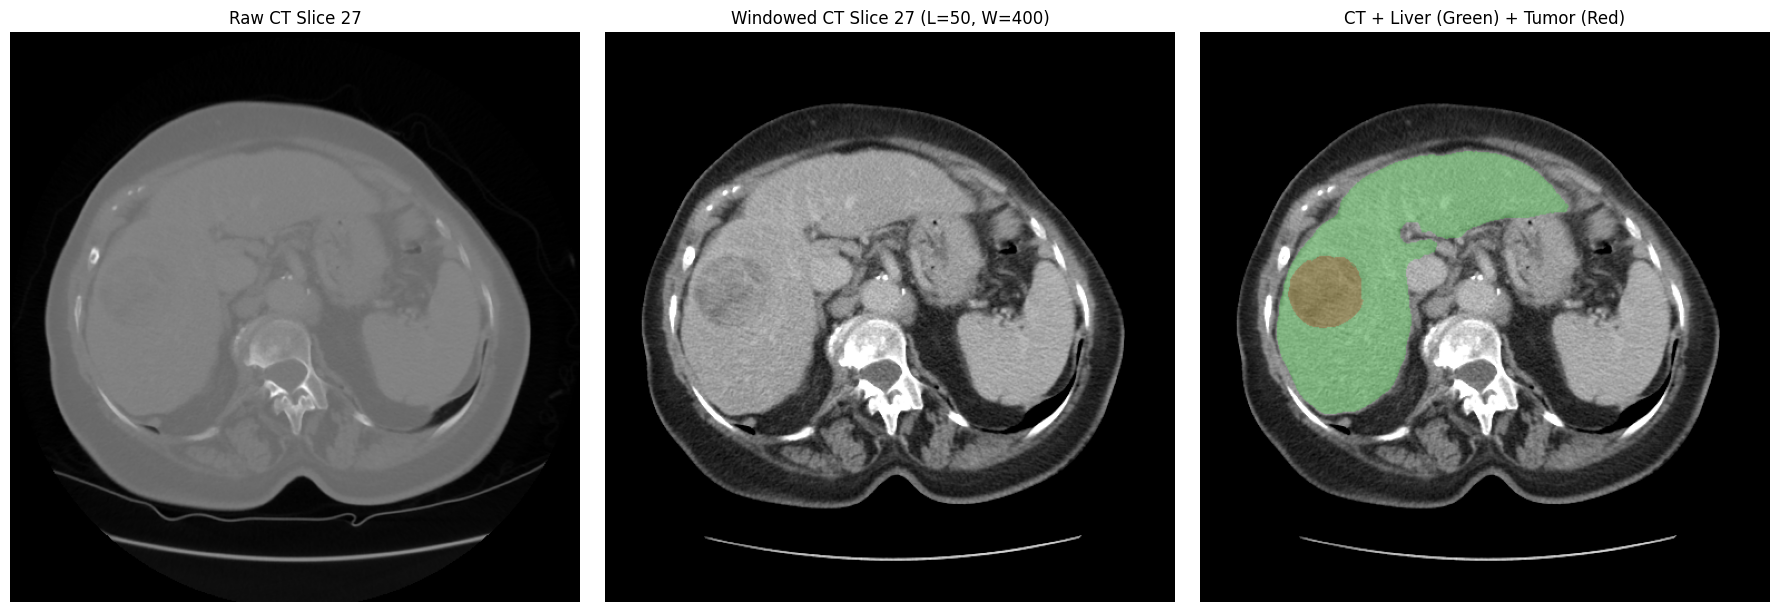

Processing Slice Index: 28, Z-Position: -102.12


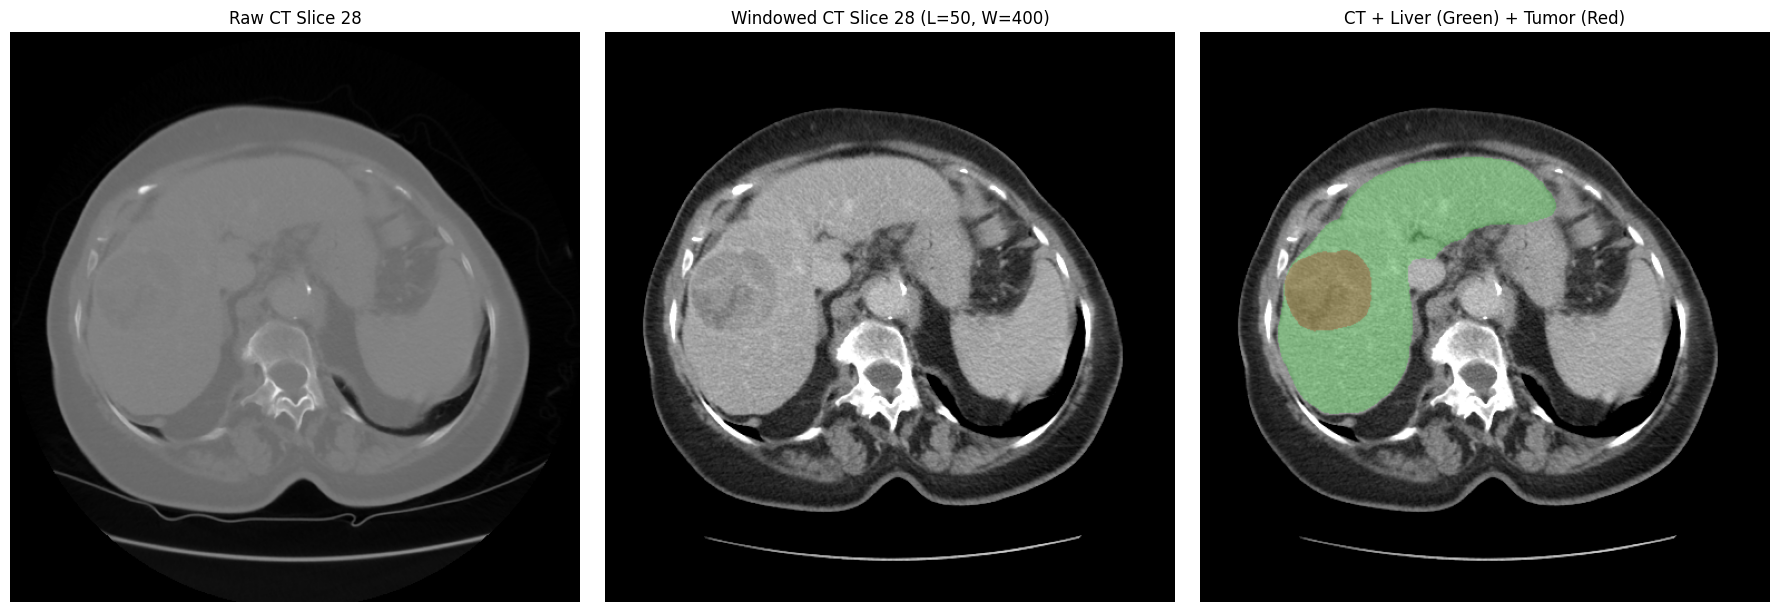

Processing Slice Index: 29, Z-Position: -97.12


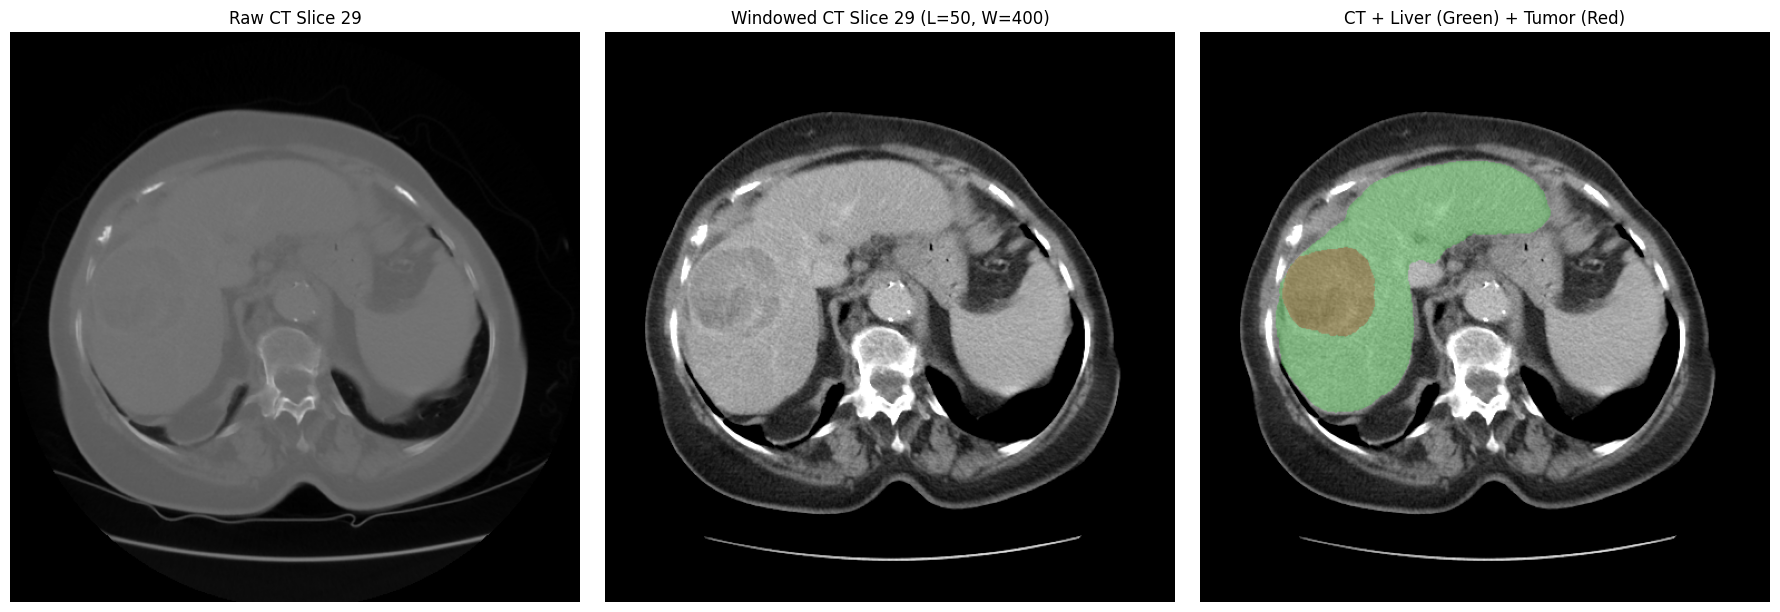

Reached display limit (7 slices). Stopping visualization.

Visualized 7 slices.


In [10]:
# Visualization Parameters 
window_level = 50         # Soft tissue window level
window_width = 400        # Soft tissue window width
liver_color = (0.0, 1.0, 0.0)   # Green
tumor_color = (1.0, 0.0, 0.0)   # Red
alpha = 0.2              # Transparency for overlay
max_slices_to_display = 7

print("\nVisualizing slices containing both Liver and Tumor masks...")

found_slices_count = 0

# Loop through CT slices and their corresponding segmentations
for i, ct_slice_info in enumerate(ref_ct_slices):
    ct_slice_data = ct_slice_info['dataset'].pixel_array
    ct_slice_z_pos = ct_slice_info['z_pos']

    # Match segmentations by Z-position
    slice_segmentations = None
    for seg_z, masks in segmentations.items():
        if np.isclose(ct_slice_z_pos, seg_z, atol=1e-3):
            slice_segmentations = masks
            break

    # Continue only if both masks exist
    if not (slice_segmentations and 'Liver' in slice_segmentations and 'Tumor' in slice_segmentations):
        continue

    if found_slices_count >= max_slices_to_display:
        print(f"Reached display limit ({max_slices_to_display} slices). Stopping visualization.")
        break

    found_slices_count += 1
    print(f"Processing Slice Index: {i}, Z-Position: {ct_slice_z_pos:.2f}")

    # Apply windowing and convert to RGB
    ct_windowed = apply_window(ct_slice_data, level=window_level, width=window_width)
    ct_rgb = np.stack([ct_windowed] * 3, axis=-1)

    # Apply Liver mask overlay
    liver_mask = slice_segmentations['Liver'] > 0
    fused_img = apply_alpha_overlay(ct_rgb, liver_mask, liver_color, alpha)

    # Apply Tumor mask overlay
    tumor_mask = slice_segmentations['Tumor'] > 0
    fused_img = apply_alpha_overlay(fused_img, tumor_mask, tumor_color, alpha)

    # Visualize
    plt.figure(figsize=(18, 6))

    # Raw CT (pre-windowing)
    plt.subplot(1, 3, 1)
    plt.imshow(ct_slice_data, cmap='gray')
    plt.title(f'Raw CT Slice {i}')
    plt.axis('off')

    # Windowed CT image
    plt.subplot(1, 3, 2)
    plt.imshow(ct_windowed, cmap='gray')
    plt.title(f'Windowed CT Slice {i} (L={window_level}, W={window_width})')
    plt.axis('off')

    # Composite with overlays
    plt.subplot(1, 3, 3)
    plt.imshow(fused_img)
    plt.title(f'CT + Liver (Green) + Tumor (Red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if found_slices_count == 0:
    print("No slices found containing both Liver and Tumor segmentations.")
else:
    print(f"\nVisualized {found_slices_count} slices.")

#### Construct the 3D Tumor Mask Volume
Once we’ve confirmed the spatial alignment of the CT slices and segmentation masks, the next step is to construct a 3D tumor mask volume. This volume will have the same spatial dimensions as the CT image and will store the tumor masks across all relevant slices.

Here’s how I approached it:

1. Initialize the 3D mask volume:
I extracted the number of rows and columns from the first CT slice (since all slices share the same shape) and initialized an empty 3D array with shape (rows, cols, num_slices). I used float32 as the data type to allow for flexibility in case we want to apply interpolation later on, though uint8 would be sufficient for binary masks.

2. Loop through each CT slice and match with segmentation data:
For every CT slice, I retrieved its z-position and searched the segmentations dictionary for the closest matching z-position. Because floating-point precision can introduce small mismatches, I used np.isclose() with a small tolerance (atol=1e-3) to make sure the match is valid.

3. Insert tumor masks into the volume:
If a tumor mask was found for the current slice and its dimensions matched the expected CT size, it is inserted into the corresponding slice index in the 3D mask volume. The mask was cast to uint8 to ensure binary values (0 for background, 1 for tumor region).

In [11]:
print("\nConstructing 3D Tumor Mask Volume...")

if not ref_ct_slices: # Check if CT slices are still available in the environment
    raise ValueError("Error: Cannot construct 3D mask without loaded CT slices.")

# Determine dimensions from the first loaded CT slice (all slices are of the same size)
rows = ref_ct_slices[0]['rows']
cols = ref_ct_slices[0]['cols']
num_slices = len(ref_ct_slices)

# Initialize an empty 3D volume for the tumor mask
# Using float32 initially might be better if interpolation is used later,
# but uint8 is fine for binary masks and MIP. Let's use uint8.
tumor_mask_3d = np.zeros((rows, cols, num_slices), dtype=np.int8)
print(f"Initialized 3D mask volume with shape: ({rows}, {cols}, {num_slices})")

# Populate the 3D mask volume
slices_with_tumor_mask = 0
for k, slice_info in enumerate(ref_ct_slices):
    ct_slice_z_pos = slice_info['z_pos']

    # Find corresponding segmentation masks for this slice's Z-position
    slice_segmentations = None
    # Use tolerance for floating point comparison
    # A more robust way might be to find the closest key if exact match fails
    closest_seg_z = min(segmentations.keys(), key=lambda z: abs(z - ct_slice_z_pos), default=None)

    if closest_seg_z is not None and np.isclose(ct_slice_z_pos, closest_seg_z, atol=1e-3): 
        slice_segmentations = segmentations[closest_seg_z]

    # Check if a 'Tumor' mask exists for this slice
    if slice_segmentations and 'Tumor' in slice_segmentations:
        tumor_mask_2d = slice_segmentations['Tumor']
        # Ensure the mask dimensions match the CT slice dimensions
        if tumor_mask_2d.shape == (rows, cols):
            tumor_mask_3d[:, :, k] = tumor_mask_2d.astype(np.uint8) # Place the 2D mask into the 3D volume
            slices_with_tumor_mask += 1
        else:
            print(f"Warning: Dimension mismatch for tumor mask at Z={ct_slice_z_pos:.2f}. Expected ({rows},{cols}), got {tumor_mask_2d.shape}. Skipping slice {k}.")
    # else:
        # print(f"Debug: No tumor mask found for CT slice {k} at Z={ct_slice_z_pos:.2f}")


if slices_with_tumor_mask == 0:
    print("\nError: No tumor masks were found or matched to the CT slices. Cannot generate MIP animation.")
    # TODO: Add visualization of loaded slices here if needed for debugging. For now we can proceed
else:
    print(f"\nSuccessfully populated 3D tumor mask volume using data from {slices_with_tumor_mask} slices.")




Constructing 3D Tumor Mask Volume...
Initialized 3D mask volume with shape: (512, 512, 42)

Successfully populated 3D tumor mask volume using data from 14 slices.


In [12]:
# Let's find out the unique labels in the tumor mask
# This will help us identify the regions of interest (ROIs) in the mask
unique_labels = np.unique(tumor_mask_3d)
roi_labels = unique_labels[unique_labels != 0]

print("Regions of Interest:", roi_labels)

Regions of Interest: [1]


#### Generate Rotating MIP Animation
After constructing the 3D tumor mask volume, we proceed to creating a rotating Maximum Intensity Projection (MIP) animation to visually explore the tumor distribution across different anatomical planes and viewing angles. This helps to better understand the tumor’s spatial extent within the body, especially when dealing with complex 3D shapes.

Here’s how I approached the animation:

1. Setting up rotation and projection parameters:
The 3D volume is rotated around the Superior-Inferior (SI) axis. The rotation is performed in the plane defined by the Right-Left and Anterior-Posterior axes. MIP projections are computed along the Coronal and Sagittal planes.

2. Defining rotation angles:
A complete 360° rotation is divided into 60 equally spaced frames, providing a smooth and continuous animation.

3. Rotating the volumes:
At each rotation angle, both the CT volume and the 3D tumor mask are rotated. The volume shape is preserved by disabling reshaping during rotation.

4. Computing MIP slices:
After rotation, Maximum Intensity Projections are computed along the Coronal and Sagittal axes for both the CT and tumor volumes.

5. Normalizing CT MIPs:
Normalization is applied to the CT MIPs to scale intensity values to the [0, 1] range. This normalization prepares the images for RGB rendering and overlay.

6. Applying tumor mask overlays:
RGB versions of the CT MIPs are generated, and the tumor masks are applied using alpha blending with a red color overlay. 

7. Rendering and storing animation frames:
For each frame, side-by-side views of the Coronal and Sagittal MIPs are rendered. The rendered images are captured from the figure canvas and stored as RGB frames.

8. Saving the animated GIF:
After all frames are generated, they are compiled into a GIF file and saved. The animation is set to loop infinitely for continuous playback.

This rotating MIP animation serves as a valuable visualization tool, which gives a good overview of tumor structure and orientation within the scanned volume. The result is embedded below


In [13]:
# Let's print some useful orientation information about the slices
# This is useful for understanding the spatial orientation of the slices
d1 = ref_ct_slices[0]['dataset'] 
d2 = ref_ct_slices[1]['dataset']
print("Orientation:", d1.ImageOrientationPatient)
print("Position:", d1.ImagePositionPatient)
print("Patient Position:", d1.PatientPosition)

print("Orientation:", d2.ImageOrientationPatient)
print("Position:", d2.ImagePositionPatient)
print("Patient Position:", d2.PatientPosition)

print("\n")
print("Pixel Spacing:", d1.PixelSpacing)
print("Slice Thickness:", d1.SliceThickness)

Orientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
Position: [-181.754684, -153.064056, -242.125000]
Patient Position: FFS
Orientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
Position: [-181.754684, -153.064056, -237.125000]
Patient Position: FFS


Pixel Spacing: [0.703125, 0.703125]
Slice Thickness: 5.000000


In [14]:
def create_mip_animation(ct_volume=ct_volume, tumor_mask_3d=tumor_mask_3d, output_gif_path='mip_animation.gif'):
    """
    Generates a rotating MIP animation showing CT overlayed with tumor mask.
    Includes Coronal, and Sagittal views.
    """
    if ct_volume is None or tumor_mask_3d is None:
         print("\nSkipping MIP animation: Input volume or mask is missing.")
         return
    if np.sum(tumor_mask_3d) == 0:
        print("\nSkipping MIP animation generation as tumor mask is empty.")
        return

    print("\nGenerating Rotating MIP Animation with Overlay (Axial, Coronal, Sagittal)...")

    # Parameters for MIP 
    # Assuming input shape is (Rows=y, Cols=x, Slices=z)
    rotation_axis = 2  # Axis to rotate around (z = Superior-Inferior)
    view_axes = (1, 0) # The plane defined by these axes will be rotated (y, x plane)
    mip_axis_coronal = 1  # Axis to project along for Coronal MIP (x)
    mip_axis_sagittal = 0 # Axis to project along for Sagittal MIP (y)

    num_frames = 60    # Number of frames/angles in the animation
    rotation_degrees = 360 # Total rotation angle
    gif_duration = 100 # milliseconds per frame
    window_level = 50  # Window level for CT MIP display
    window_width = 400 # Window width for CT MIP display
    alpha_overlay = 0.2 # Transparency for tumor overlay

    # Generate Frames 
    rotated_mip_frames = []
    angles = np.linspace(0, rotation_degrees, num_frames, endpoint=False)

    print(f"Generating {num_frames} frames...")
    for i, angle in enumerate(angles):
        # Rotate volumes 
        # Rotate the tumor mask (use nearest neighbor order=0 for masks)
        rotated_mask = scipy.ndimage.rotate(
            tumor_mask_3d, angle=angle, axes=view_axes, reshape=False,
            order=0, mode='constant', cval=0.0
        ).astype(np.uint8)

        # Rotate the CT volume
        rotated_ct = scipy.ndimage.rotate(
            ct_volume, angle=angle, axes=view_axes, reshape=False,
            order=1, mode='nearest' # Use bilinear for CT
        )

        # Generate CT MIPs 
        ct_mip_coronal = np.max(rotated_ct, axis=mip_axis_coronal)
        ct_mip_sagittal = np.max(rotated_ct, axis=mip_axis_sagittal)

        # Normalize CT MIPs using windowing 
        #TODO: Ask Dr. Biblioni if we need to normalize the MIPs or just use the raw values
        ct_mip_coronal_norm = apply_window(ct_mip_coronal, level=window_level, width=window_width)
        ct_mip_sagittal_norm = apply_window(ct_mip_sagittal, level=window_level, width=window_width)

        # Generate Tumor MIPs 
        tumor_mip_coronal = np.max(rotated_mask, axis=mip_axis_coronal)
        tumor_mip_sagittal = np.max(rotated_mask, axis=mip_axis_sagittal)

        # Overlay tumor mask on CT MIPs 
        # Helper function for overlay
        def overlay_mip(ct_img_norm, tumor_mask, alpha=0.4, tumor_color=(1, 0, 0)):
            rgb = np.stack([ct_img_norm] * 3, axis=-1)
            mask_bool = tumor_mask > 0
            for c_idx in range(3):
                rgb[..., c_idx][mask_bool] = (
                    (1 - alpha) * rgb[..., c_idx][mask_bool] + alpha * tumor_color[c_idx]
                )
            return (rgb * 255).astype(np.uint8)

        fused_coronal = overlay_mip(ct_mip_coronal_norm, tumor_mip_coronal, alpha=alpha_overlay)
        fused_sagittal = overlay_mip(ct_mip_sagittal_norm, tumor_mip_sagittal, alpha=alpha_overlay)
       
        # Need to rotate coronal and sagittal views for standard display orientation
        fused_coronal_disp = np.rot90(fused_coronal, k=1)
        fused_sagittal_disp = np.rot90(fused_sagittal, k=1)

        fig, axes = plt.subplots(1, 2, figsize=(14, 8), facecolor='black') 
        fig.suptitle(f'Rotated Tumor MIP Overlay (Angle: {angle:.1f}°)', color='white', fontsize=14)

        axes[0].imshow(fused_coronal_disp, aspect='auto') # Use auto aspect for non-square pixels potentially
        axes[0].set_title('Coronal MIP', color='white')
        axes[0].axis('off')

        axes[1].imshow(fused_sagittal_disp, aspect='auto') 
        axes[1].set_title('Sagittal MIP', color='white')
        axes[1].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout

        # Render frame 
        fig.canvas.draw()
        frame_rgba = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame_rgb = frame_rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
        plt.close(fig) 
        rotated_mip_frames.append(frame_rgb)

        if (i + 1) % 10 == 0: # Print progress every 10 frames
             print(f"  Generated frame {i+1}/{num_frames}")

    # Save Frames as GIF 
    print(f"\nSaving animation to {output_gif_path}...")
    if rotated_mip_frames:
        imageio.mimsave(output_gif_path, rotated_mip_frames, duration=gif_duration, loop=0) # loop=0 means infinite loop
        print(f"GIF saved successfully to {output_gif_path}")
    else:
        print("No frames were generated for the GIF.")

In [52]:
create_mip_animation(ct_volume, tumor_mask_3d, output_gif_path='mip_animation.gif')


Generating Rotating MIP Animation with Overlay (Axial, Coronal, Sagittal)...
Generating 60 frames...
  Generated frame 10/60
  Generated frame 20/60
  Generated frame 30/60
  Generated frame 40/60
  Generated frame 50/60
  Generated frame 60/60

Saving animation to mip_animation.gif...
GIF saved successfully to mip_animation.gif


![MIP Animation](mip_animation.gif)

### Task 2: 3D Image Segmentation
In this task, a semi-automatic segmentation approach is applied to refine the tumor mask using intensity-based region growing. We begin by computing spatial characteristics such as the bounding box and centroid.

Steps:

1. Extracting Tumor Region Properties:
The input 3D tumor mask is first validated to ensure that it contains non-zero voxels. The following steps are then performed:
    - Bounding Box Calculation:  
    A bounding box is computed by identifying the minimum and maximum voxel indices along each axis where the tumor mask is positive. This will be used as a spatial constraint for the region of interest.

    - Centroid Calculation:
    The centroid (center of mass) of the tumor region is calculated. This value serves as the seed point for the subsequent segmentation process. The centroid is arranged in (row, column, slice) order.

2. Preparing for Region Growing Segmentation:
The centroid coordinates are converted to (x, y, z) format, where the axes represent (column, row, slice). Using this seed point, the CT intensity value at the centroid is extracted. A lower and upper intensity threshold is defined using a fixed tolerance around this value (e.g., ±10 HU). These thresholds define the intensity range for including voxels in the segmented region.


3. Performing Region Growing Segmentation:
The segmentation is carried out using the `ConnectedThresholdImageFilter` from SimpleITK:

- The CT volume is transposed to match SimpleITK’s (z, y, x) memory layout before conversion.
- A light Gaussian smoothing (`sigma=1.0`) is applied to reduce noise in the CT volume.
- Region growing is performed starting from the seed point using the specified intensity range.
- The resulting binary mask is post-processed as follows:
  - Connected Component Labeling: Connected regions are identified and sorted by size.
  - Largest Component Extraction: The largest connected region is assumed to correspond to the tumor.
  - Morphological Closing: A closing operation is applied using a structuring element of size [7, 7, 3] to fill small gaps and smooth the mask.


#### Extracting Tumor Bounding-Box and Centroid

In [12]:
# Let's start by checking and printing some basic information
if tumor_mask_3d is None or np.sum(tumor_mask_3d) == 0:
    raise Exception("Error: The tumor mask is empty or not loaded. Cannot proceed.")

print(f"Extracting Bounding Box and Centroid")
print(f"Input tumor mask shape: {tumor_mask_3d.shape}")
print(f"Number of tumor voxels: {np.sum(tumor_mask_3d)}")

# Calculate 3D Bounding Box 
# Find the indices where the mask is non-zero
coords = np.argwhere(tumor_mask_3d > 0) # Returns N x 3 array of [row, col, slice] indices

if coords.size == 0:
    print("Error: No positive voxels found in the mask to calculate bounding box.")
    bbox = None
else:
    # Find min and max coordinates along each axis
    r_min, c_min, s_min = coords.min(axis=0)
    r_max, c_max, s_max = coords.max(axis=0)

    # Bounding box format: (min_row, min_col, min_slice, max_row, max_col, max_slice)
    # Note: max values are inclusive indices
    bbox = (r_min, c_min, s_min, r_max, c_max, s_max)
    print("\nCalculated Bounding Box (min_row, min_col, min_slice, max_row, max_col, max_slice):")
    print(f"  {bbox}")
    print(f"  Dimensions (R, C, S): ({r_max-r_min+1}, {c_max-c_min+1}, {s_max-s_min+1})")


# Calculate Centroid 
# The centroid is the geometric center (center of mass for a binary mask)
# We can use scipy.ndimage.center_of_mass to calculate this directly
# Input should be the mask itself according to the docs.
centroid = None
if coords.size > 0:
    try:
        # Returns coordinates in (row, col, slice) order
        centroid = scipy.ndimage.center_of_mass(tumor_mask_3d)
        print("\nCalculated Centroid (row, col, slice):")
        # Format to reasonable precision for printing
        print(f"  ({centroid[0]:.2f}, {centroid[1]:.2f}, {centroid[2]:.2f})")
    except Exception as e:
        print(f"Error calculating centroid: {e}")
else:
     print("\nCannot calculate centroid: No positive voxels found in the mask.")


Extracting Bounding Box and Centroid
Input tumor mask shape: (512, 512, 42)
Number of tumor voxels: 48646

Calculated Bounding Box (min_row, min_col, min_slice, max_row, max_col, max_slice):
  (np.int64(131), np.int64(74), np.int64(18), np.int64(280), np.int64(310), np.int64(36))
  Dimensions (R, C, S): (150, 237, 19)

Calculated Centroid (row, col, slice):
  (233.28, 119.62, 30.79)


#### Estimating Tumor region using Region Growing Algorithm

In [14]:
print(f"Semi-Automatic Segmentation using Region Growing Algorithm")

tumor_mask_3d_segmented = None # Initialize segmented mask

if centroid is not None:
    # Parameters for ConnectedThreshold 
    # Convert float centroid coordinates to integer indices for seed point
    # Note: According to the docs, SimpleITK uses (x, y, z) = (col, row, slice) convention for coordinates!
    # So we need to convert from (row, col, slice) to (col, row, slice)
    seed_point = (int(centroid[1]), int(centroid[0]), int(centroid[2])) # (col, row, slice)

    # Determine intensity thresholds. This threshold is sensitive and requires tuning.
    # Strategy: We can use intensity at seed point +/- a tolerance
    try:
        seed_intensity = ct_volume[int(centroid[0]), int(centroid[1]), int(centroid[2])]
        intensity_tolerance = 4 # Tolerance in HU - (I experimentally found this value to work well)
        # Set lower and upper thresholds based on seed intensity and tolerance
        lower_threshold = int(seed_intensity - intensity_tolerance)
        upper_threshold = int(seed_intensity + intensity_tolerance)
        print(f"Using intensity at seed {seed_point}: {seed_intensity:.2f} HU")
        print(f"Setting thresholds: Lower={lower_threshold}, Upper={upper_threshold}")
    except IndexError:
         print(f"Error: Centroid {seed_point} is outside the CT volume bounds {ct_volume.shape}. Cannot determine seed intensity.")
         lower_threshold, upper_threshold = None, None # Prevent proceeding

    if lower_threshold is not None and upper_threshold is not None:
        try:
            # Convert NumPy CT volume to SimpleITK image
            # Note: We have to ensure that ct_volume is in a suitable format (e.g., int16, float32) according to the docs
            # SimpleITK expects image data in (z, y, x) = (slice, row, col) order when creating from NumPy
            # but uses (x,y,z) for functions like SetSeed. Let's transpose if needed.
            # Note: ct_volume is originally in (row, col, slice) from previous task 1:
            ct_volume_sitk = sitk.GetImageFromArray(ct_volume.transpose(2, 0, 1)) # Transpose to (slice, row, col)

            # Perform Region Growing 
            region_grower = sitk.ConnectedThresholdImageFilter()
            region_grower.SetSeedList([seed_point]) # Set the starting point (x, y, z)
            region_grower.SetLower(lower_threshold)    # Minimum intensity to include
            region_grower.SetUpper(upper_threshold)    # Maximum intensity to include
            # region_grower.SetReplaceValue(1) # Value to assign to segmented pixels 

            print("Running SimpleITK ConnectedThreshold filter...")
            # Apply smoothing to the CT volume before segmentation
            ct_smoothed = sitk.SmoothingRecursiveGaussian(ct_volume_sitk, sigma=1.0)
            # Perform region growing on the smoothed image
            segmented_mask_sitk = region_grower.Execute(ct_smoothed)

            # Find  connected component in the segmented mask
            cc = sitk.ConnectedComponent(segmented_mask_sitk)
            relabeled = sitk.RelabelComponent(cc, sortByObjectSize=True) # Relabel components by size
            # Keep the largest component (assuming it's the tumor)
            largest_component = relabeled == 1
            # Perform morphological closing to fill small holes in the segmented mask
            closed = sitk.BinaryMorphologicalClosing(largest_component, [15, 15, 5]) # expeerimentally worked well

            # Convert the resulting SimpleITK mask back to NumPy array
            # The output array will be in (slice, row, col) order
            segmented_mask_np = sitk.GetArrayFromImage(closed)

            # Transpose back to original (row, col, slice) order to match input/ground truth
            tumor_mask_3d_segmented = segmented_mask_np.transpose(1, 2, 0)

            print(f"Segmentation finished. Result shape: {tumor_mask_3d_segmented.shape}")
            print(f"Number of segmented voxels: {np.sum(tumor_mask_3d_segmented)}")

        except Exception as e:
            print(f"Error during SimpleITK region growing: {e}")
            tumor_mask_3d_segmented = None # Ensure it's None if error occurs
    else:
        print("Skipping segmentation due to invalid thresholds.")

else:
    print("Skipping segmentation: Centroid was not calculated successfully.")


Semi-Automatic Segmentation using Region Growing Algorithm
Using intensity at seed (119, 233, 30): 91.00 HU
Setting thresholds: Lower=87, Upper=95
Running SimpleITK ConnectedThreshold filter...
Segmentation finished. Result shape: (512, 512, 42)
Number of segmented voxels: 58351


#### Evaluation and Comparison
After generating the 3D tumor segmentation using region growing, both quantitative and qualitative evaluations are carried out to assess the performance of the segmentation relative to the ground truth mask.

Here are the steps I took:

1. Numerical Evaluation
To quantify segmentation accuracy, the following performance metrics are computed:
    - Dice Similarity Coefficient (DSC): 
    Measures the overlap between the predicted and ground truth masks. It is defined as:  
    $$
    DSC = \frac{2 \cdot |A \cap B|}{|A| + |B|}
    $$ 
    where \( A \) and \( B \) are the binary masks. This is equivalent to the F1-score for binary classification.

    - Precision: Indicates the proportion of predicted positive voxels that are truly positive.

    - Sensitivity (Recall): Reflects the proportion of actual positive voxels correctly identified by the segmentation.

    - Specificity: Measures the proportion of negative voxels correctly excluded from the segmented region.

These metrics are computed using pixel-wise comparisons between the segmented mask and the reference mask. 

2. Visual Comparison
For visual assessment, a representative 2D slice is selected—specifically, the slice corresponding to the z-index of the computed tumor centroid. The following visualizations are  generated:

- CT slice with ground truth contour: 
  The original CT slice is shown with the ground truth tumor mask overlaid in red.

- CT slice with segmented mask contour:  
  The same CT slice is shown with the predicted segmentation overlaid in lime green.

- Combined overlay of both masks:
  Both the ground truth and predicted segmentation masks are overlaid on the CT slice using different contour styles. This allows for easy assessment of discrepancies visually.

In addition to the plots, the computed performance metrics (Precision, Sensitivity, Specificity, F1-score) are displayed to aid evaluation of the algorithm’s performance.

In [15]:
def dice_coefficient(mask1, mask2):
    """
    Compute the Dice Similarity Coefficient (DSC) between two binary masks.
    DSC = 2 * |A intersect B| / (|A| + |B|)
    """
    # Ensure boolean type
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    intersection = np.sum(mask1 & mask2)
    volume1 = np.sum(mask1)
    volume2 = np.sum(mask2)

    # Handle potential division by zero
    if volume1 + volume2 == 0:
        return 1.0 if intersection == 0 else 0.0 # Both empty or identical empty masks
    else:
        return 2.0 * intersection / (volume1 + volume2)
    
def perpixel_performance_measures(mask_reference, mask_prediction):
    """Compute TP, TN, FP, FN from binary masks."""
    true_positives = np.sum((mask_reference == 1) & (mask_prediction == 1))
    true_negatives = np.sum((mask_reference == 0) & (mask_prediction == 0))
    false_positives = np.sum((mask_reference == 0) & (mask_prediction == 1))
    false_negatives = np.sum((mask_reference == 1) & (mask_prediction == 0))
    return true_positives, true_negatives, false_positives, false_negatives

def perimage_performance_measures(mask_reference, mask_prediction):
    """Compute sensitivity, specificity, and F1-score from binary masks."""
    tp, tn, fp, fn = perpixel_performance_measures(mask_reference, mask_prediction)
    sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) else 0.0
    return precision, sensitivity, specificity, f1_score


Calculating Numerical Metrics...
  Dice Similarity Coefficient (DSC): 0.6512
  Precision: 0.5970
  Sensitivity: 0.7161
  Specificity: 0.9979
  F1-score: 0.6512

Generating Visual Comparison...
Displaying comparison for slice index: 30


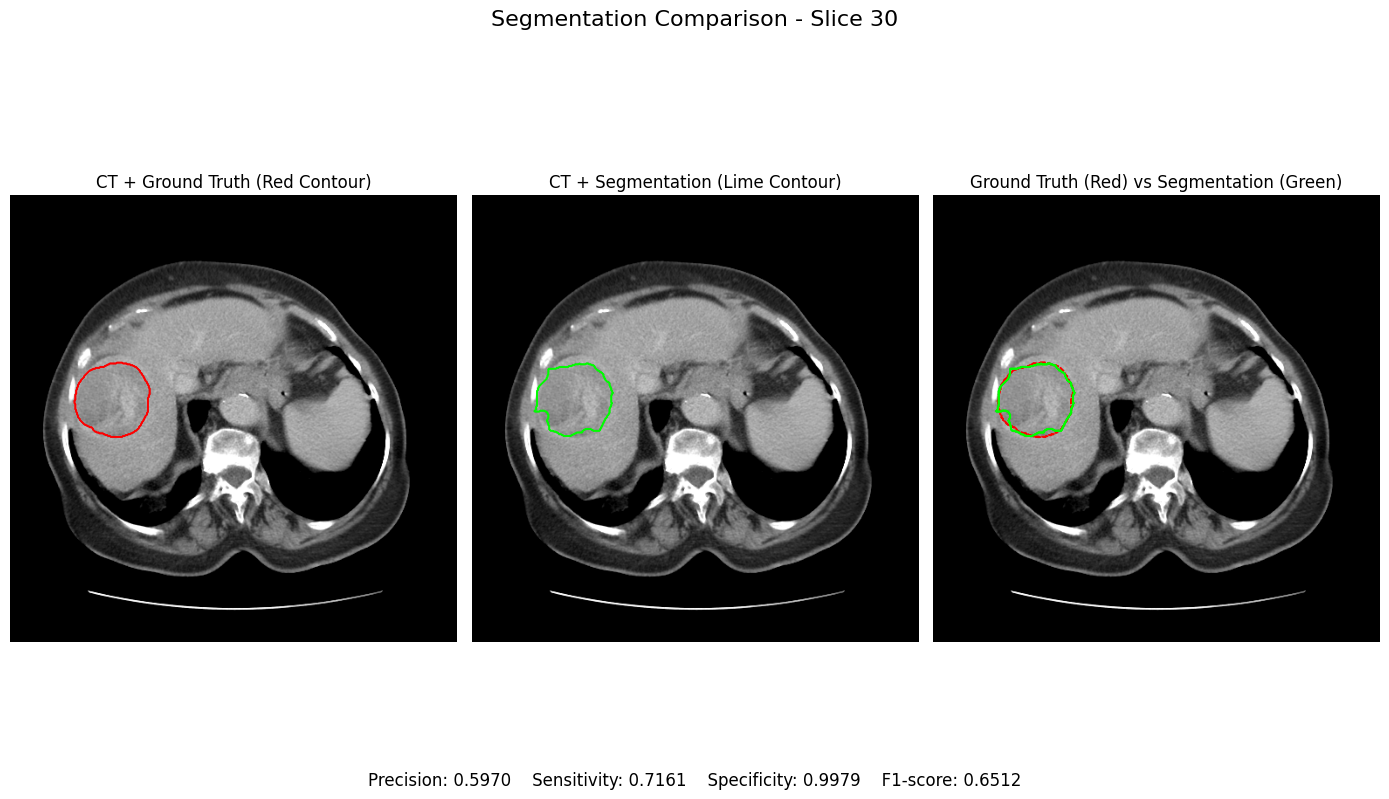

In [16]:
if tumor_mask_3d_segmented is None:
    print("Segmentation was not performed or failed. Cannot evaluate.")
else:
    # Numerical Evaluation
    print("\nCalculating Numerical Metrics...")
    dsc_score = dice_coefficient(tumor_mask_3d, tumor_mask_3d_segmented) # This is the same as F1 score for binary masks
    print(f"  Dice Similarity Coefficient (DSC): {dsc_score:.4f}")
    # TODO: Add other metrics like Jaccard, Hausdorff Distance, Precision, Sensitivity, etc.
    precision, sensitivity, specificity, f1_score = perimage_performance_measures(tumor_mask_3d, tumor_mask_3d_segmented)
    print(f"  Precision: {precision:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  F1-score: {f1_score:.4f}")
   

    # Visual Evaluation 
    print("\nGenerating Visual Comparison...")

    # Select a representative slice (e.g., the slice containing the centroid)
    if centroid is not None:
        slice_idx = int(centroid[2]) # Z-axis index (slice)
        print(f"Displaying comparison for slice index: {slice_idx}")

        # Get the 2D slices for CT, ground truth, and segmentation
        ct_slice = ct_volume[:, :, slice_idx]
        gt_mask_slice = tumor_mask_3d[:, :, slice_idx]
        seg_mask_slice = tumor_mask_3d_segmented[:, :, slice_idx]

        # Apply windowing to CT slice for better visualization
        window_level = 50
        window_width = 400
        ct_slice_windowed = apply_window(ct_slice, level=window_level, width=window_width)

        # Create plot
        fig, axes = plt.subplots(1, 3, figsize=(14, 8))
        fig.suptitle(f'Segmentation Comparison - Slice {slice_idx}', fontsize=16)

        # Plot  CT + Ground Truth Overlay
        axes[0].imshow(ct_slice_windowed, cmap='gray')
        # Overlay ground truth mask (e.g., red contour)
        axes[0].contour(gt_mask_slice, colors='red', linewidths=0.8, alpha=0.7)
        axes[0].set_title('CT + Ground Truth (Red Contour)')
        axes[0].axis('off')

        # Plot CT + Segmented Mask Overlay
        axes[1].imshow(ct_slice_windowed, cmap='gray')
        # Overlay segmented mask (e.g., lime contour)
        axes[1].contour(seg_mask_slice, colors='lime', linewidths=0.8, alpha=0.7)
        axes[1].set_title('CT + Segmentation (Lime Contour)')
        axes[1].axis('off')

        # Plot Both Masks Overlayed (different colors/styles)
        axes[2].imshow(ct_slice_windowed, cmap='gray')
        axes[2].contour(gt_mask_slice, colors='red', linewidths=1.0, linestyles='dashed', alpha=0.8)
        axes[2].contour(seg_mask_slice, colors='lime', linewidths=1.0, alpha=0.8)
        axes[2].set_title('Ground Truth (Red) vs Segmentation (Green)')
        axes[2].axis('off')

        metrics_text = (
            f"Precision: {precision:.4f}    " # The spaces are important for display
            f"Sensitivity: {sensitivity:.4f}    "
            f"Specificity: {specificity:.4f}    "
            f"F1-score: {f1_score:.4f}"
        )

        # Add the text to the figure (centered below subplots)
        fig.text(0.5, 0.01, metrics_text, ha='center', fontsize=12, color='black')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
        plt.show()

    else:
        print("Cannot determine central slice for visualization as centroid is missing.")
        # TODO: I will add code to visualize a different slice if needed
        

[Click here to return to Table of Content](#table-of-content)